# Weights

In [1]:
#| default_exp weights
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *

%load_ext autoreload
%autoreload 2
! date

Fri Jan 20 02:40:35 PST 2023


## Weight tables
We use a full-sky catalog analysis model, currently pointlike, see the generation code: [source_weights.py](https://github.com/tburnett/pointlike/blob/master/python/uw/like2/source_weights.py), which evaluates the predicted flux from a source of interest with respect to the
background, the combined fluxes from all other sources. 

The binning is in:

* energy:  4/decade from 100 MeV to 1 TeV (but only upto 10 GeV really used)
* event types: Front/Back  
* Angular position: HEALPix, nside from 64 to 512 depending on the PSF 

In the tables, the energy index and event type are packed into a 1-byte band index, and the 4-byte HEALPix index 
is in NEST order.

The table output also includes the predicted flux for each band, and the spectral model used.

### Plots of weight vs. radius

These plots, of a strong source with little background, and a weak one, show the
value of the weight vs. the radius of the pixels in the table. These is a 
plot for each energy/event type band. The top row has energies 100 MeV to 1 GeV,
the bottom row 1 GeV to 10 GeV, Front, in green, and Back in orange.
<figure style="margin-left: 25px" title="Figure 1">   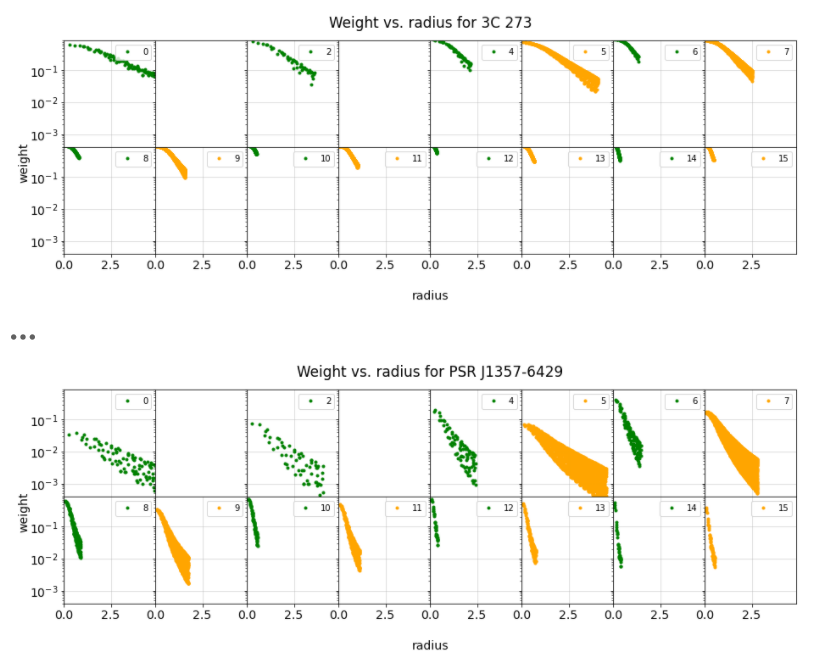 </figure>
Note the absense of Back for energies below 316 MeV. The pointlike model does not
compute these to avoid the larger PSF and Earth limb background. The maximum radius
per band is determined by the PSF. 


In [2]:
#| code-fold: true
@ipynb_doc
def weight_table_plots():
    """
    ### Plots of weight vs. radius
    
    These plots, of a strong source with little background, and a weak one, show the
    value of the weight vs. the radius of the pixels in the table. These is a 
    plot for each energy/event type band. The top row has energies 100 MeV to 1 GeV,
    the bottom row 1 GeV to 10 GeV, Front, in green, and Back in orange.
    {img}
    Note the absense of Back for energies below {Emid} MeV. The pointlike model does not
    compute these to avoid the larger PSF and Earth limb background. The maximum radius
    per band is determined by the PSF. 
    """
    Emid = round(10**2.5)
    img = image('weight_table_plots.png', caption=None)
    return locals()
weight_table_plots()

The local code used to do the unpacking is in the class `WeightMan`

This table is used with the data, as a simple lookup: A weight is assigned to each photon according to which energy, event type or HEALPix pixel it lands in.

In [3]:
#| include: false
from wtlike.config import *
import zipfile
from pathlib import Path
config = Config()
if config.valid:
    datapath=Path(config.datapath)
    wtfolder =datapath/'weight_files'

    nf = len(list(wtfolder.glob('*_weights.pkl')))

    with zipfile.ZipFile(datapath/'weight_files.zip') as wtzip:
        nzip = len(wtzip.filelist)

    print(f'Weight files: {nf} in {wtfolder.name}/ and {nzip} in weight_files.zip ')

Weight files: 14 in weight_files/ and 11472 in weight_files.zip 


### Accounting for variations from neighboring sources

Consider the case where sources $S_1$ and $S_2$ have overlapping pixels. For a given pixel and band, the corresponding weights are
$w_1$ and $w_2$, and we investigate the effect on $S_1$ from a fractional variation $\alpha_2 \ne 0$ of $S_2$, such that
its flux for that pixel, $s_2$, becomes $(1+\alpha )\ s_2$. With the background $b$, the flux of all
sources besides $S_1$ and $S_2$, we have for the $S_1$ weight,

$$ w_1 = \frac{s_1}{s_1+s_2+b}\ \ ,$$

and similarly for $S_2$.
Replacing $s_2$ with $(1+\alpha ) s_2$, we have for the modified weight $w_1'$ that we should use for  $S_1$,
$$w'_1 = \frac{w_1}{1+\alpha_2\ w_2}\ \ .   $$


In [4]:
#| export
import os, sys, pickle, healpy, zipfile
from pathlib import Path
import numpy as np
import pandas as pd

from scipy.integrate import quad
from astropy.coordinates import SkyCoord, Angle
from wtlike.config import *

In [5]:
#| export
def get_wtzip_index(config, update=False):

    wtzipfile = config.datapath/'weight_files.zip'
    if not  wtzipfile.is_file():
        print( f'Did not find the zip file {wtzipfile}', file=sys.stderr)
        return None

    with  zipfile.ZipFile(wtzipfile) as wtzip:
        if 'index.pkl' in wtzip.namelist() and not update:
            zi =  pickle.load(wtzip.open('index.pkl'))
#             if 'coord' in zi:
#                 print('Updating coord in index.pkl')

            zi['coord'] = SkyCoord(zi['glon'], zi['glat'], unit='deg', frame='galactic').fk5
            return zi

        if config.verbose>0:
            print(f'sources.get_wtzip_index: Extracting info from {wtzipfile}')
        name=[]; glat=[]; glon=[]
        for filename in wtzip.namelist():
            if filename=='index.pkl': continue
            with wtzip.open(filename) as file:
                wtd = pickle.load(file, encoding='latin1')
                l,b = wtd['source_lb']
                name.append(Path(filename).name.split('_weights.pkl')[0].replace('_',' ').replace('p','+') )
                glon.append(l)
                glat.append(b)
        zip_index = dict(name=np.array(name),
                         glon=np.array(glon), glat=np.array(glat),
                         #coord= SkyCoord(glon, glat, unit='deg', frame='galactic'),
                        )

        ### write to temp file, insert back into the zip
        ### SHould be a way to just stream
        pickle.dump(zip_index, open('/tmp/wtfile_index.pkl', 'wb'))
        with zipfile.ZipFile(wtzipfile, mode='a') as wtzip:
            wtzip.write('/tmp/wtfile_index.pkl', 'index.pkl')

        zip_index['coord'] = SkyCoord(zip_index['glon'], zip_index['glat'], unit='deg', frame='galactic').fk5
    return zip_index

## WeightMan

In [6]:
#| export
class WeightMan(dict):
    """ Weight Management

    * Load weight tables
    * Assign weights to photons
    """

    def __init__(self, config, source):
        """
        """
        self.source = source
        nickname = source.nickname
        datapath =Path(config.datapath)

        filename = 'weight_files/'+nickname.replace(' ','_').replace('+','p')+'_weights.pkl'

        if (datapath/filename).exists():
            with open(datapath/filename, 'rb') as inp:
                wtd =  pickle.load(inp, encoding='latin1')

        elif (datapath/'weight_files.zip').exists():
            with  zipfile.ZipFile(datapath/'weight_files.zip') as wtzip:
                wtd =  pickle.load(wtzip.open(filename), encoding='latin1')

        else:
            raise Exception(f'No weight info found for {nickname}')

        self.update(wtd)
        self.__dict__.update(wtd)
        self.filename=filename
        self.config = config

        # check format--old has pixels, weights at tome
        srcfile = f'file "{self.filename}"' if self.source is None else f'file from source "{source.filename}"_weights.pkl'

        if hasattr(self, 'nside'):
            self.format=0
            if config.verbose>0:
                print(f'WeightMan: {srcfile} old format, nside={self.nside}')

            test_elements = 'energy_bins pixels weights nside model_name radius order roi_name'.split()
            assert np.all([x in wtd.keys() for x in test_elements]),f'Dict missing one of the keys {test_elements}'
            if config.verbose>0:
                print(f'Load weights from file {os.path.realpath(filename)}')
                pos = self['source_lb']
                print(f'\tFound: {self["source_name"]} at ({pos[0]:.2f}, {pos[1]:.2f})')
            # extract pixel ids and nside used
            self.wt_pix   = self['pixels']
            self.nside_wt = self['nside']

            # merge the weights into a table, with default nans
            # indexing is band id rows by weight pixel columns
            # append one empty column for photons not in a weight pixel
            # calculated weights are in a dict with band id keys
            self.wts = np.full((32, len(self.wt_pix)+1), np.nan, dtype=np.float32)
            weight_dict = self['weights']
            for k in weight_dict.keys():
                t = weight_dict[k]
                if len(t.shape)==2:
                    t = t.T[0] #???
                self.wts[k,:-1] = t

        else:
            self.format=1
            wtdict = self.wt_dict
            nsides = [v['nside'] for v in wtdict.values() ];

            if config.verbose>1:
                print(f'WeightMan: {srcfile} : {len(nsides)} bamds'\
                      f' with nsides {nsides[0]} to {nsides[-1]}')
            if self.source is not None:
                self.source.fit_info = self.fitinfo
                if config.verbose>2:
                    print(f'\tAdded fit info {self.fitinfo} to source')

    def _new_format(self, photons):

        wt_tables =self.wt_dict
        data_nside=1024
        photons.loc[:,'weight'] = np.nan

        if self.config.verbose>1:
            print(f'WeightMan: processing {len(photons):,} photons')

        def load_data( band_id):
            """ fetch pixels and weights for the band;
                adjust pixels to the band nside
                generate mask for pixels, weights
            """
            band = photons[photons.band==band_id] #.query('band== @band_id')
            wt_table = wt_tables[band_id]
            nside =  wt_table['nside']
            new_weights = wt_table['wts'].astype(np.float16)
            to_shift = int(2*np.log2(data_nside//nside))
            data_pixels = np.right_shift(band.nest_index, to_shift)
            wt_pixels=wt_table['pixels']
            good = np.isin( data_pixels, wt_pixels)
            if self.config.verbose>2:
                print(f'\t {band_id:2}: {len(band):8,} -> {sum(good ):8,}')
            return data_pixels, new_weights, good

        def set_weights(band_id):
            if band_id not in wt_tables.keys(): return

            data_pixels, new_weights, good = load_data(band_id)
            wt_pixels = wt_tables[band_id]['pixels']
            indicies = np.searchsorted( wt_pixels, data_pixels[good])
            new_wts = new_weights[indicies]
            # get subset of photons in this band, with new weights
            these_photons = photons[photons.band==band_id][good]
            these_photons.loc[:,'weight']=new_wts
            photons.loc[photons.band==band_id,'weight'] = (these_photons.weight).astype(np.float16)
 
        for band_id in range(16):
            set_weights(band_id)

        return photons

    def add_weights(self, photons):
        """
        get the photon pixel ids, convert to NEST (if not already) and right shift them
        add column 'weight', remove `nest_index'
        remove rows with nan weight

        """
        assert photons is not None
        photons = self._new_format(photons)
        assert photons is not None

        # don't need these columns now (add flag to config to control??)
        if not getattr(self.config, 'keep_pixels', False):
            photons.drop(['nest_index'], axis=1, inplace=True)
            if self.config.verbose>2:
                print('Keeping pixels')
        noweight = np.isnan(photons.weight.values)
        if self.config.verbose>1:
            print(f'\tremove {sum(noweight):,} events without weight')

        ret = photons[np.logical_not(noweight)]
        assert ret is not None
        return ret

In [7]:
#| include: false
show_doc(WeightMan)
show_doc(WeightMan.add_weights)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/weights.py#L177){target="_blank" style="float:right; font-size:smaller"}

### WeightMan.add_weights

>      WeightMan.add_weights (photons)

get the photon pixel ids, convert to NEST (if not already) and right shift them
add column 'weight', remove `nest_index'
remove rows with nan weight

In [8]:
#| exporti
class WTSkyCoord(SkyCoord):
    def __repr__(self):
        ra,dec = self.fk5.ra.deg, self.fk5.dec.deg
        return f'({ra:.3f},{dec:.3f})'

In [9]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Fri Jan 20 02:40:40 PST 2023
